In [1]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="kealexanderwang", project="constrained-pnns", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="kealexanderwang", project="constrained-pnns",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [2]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [3]:
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

# Pendulum data-efficiency
query = {"$and": [{"tags": "data-efficiency"},
                  {"tags": "submission"},
                  {"state": "finished"},
                  {"config.body_class": "Gyroscope"},
                  #{"config.n_train": {"$lte": 4000}},
                  {"config.lr": 3e-3},
                 ]}

runs, histories = zip(*get_history(query=query))

In [4]:
import torch

labels = []
series = []

for run in runs:
    test_log_path = load_file_from_run(run, "test_log.pt")
    test_log = torch.load(test_log_path)

    pred_zts = test_log["pred_zts"]
    true_zts = test_log["true_zts"]
    pert_zts = test_log["pert_zts"]

    network_class = run.config["network_class"]
    network_class = run.config["network_class"]
    if network_class == "NN":
        network_class = "NeuralODE"
        
    n_train = run.config["n_train"]
    #n_train = (r"$N_{train}$=", f"{n_train}")
    n_train = n_train

#     rel_err_pred_true = ((pred_zts - true_zts).pow(2).sum((2, 3, 4)) / (pred_zts + true_zts).pow(2).sum((2,3,4))).sqrt()
#     rel_err_pert_true = ((pert_zts - true_zts).pow(2).sum((2, 3, 4)) / (pert_zts + true_zts).pow(2).sum((2,3,4))).sqrt()
    rel_err_pred_true = (pred_zts - true_zts).pow(2).sum((2, 3, 4)).sqrt() / (pred_zts.pow(2).sum((2,3,4)).sqrt() + true_zts.pow(2).sum((2,3,4)).sqrt()) 
    rel_err_pert_true = (pert_zts - true_zts).pow(2).sum((2, 3, 4)).sqrt() / (pert_zts.pow(2).sum((2,3,4)).sqrt() + true_zts.pow(2).sum((2,3,4)).sqrt()) 

    #avg_rel_err_pred = rel_err_pred_true.mean(0).numpy()
    #avg_rel_err_pert = rel_err_pert_true.mean(0).numpy()
    avg_rel_err_pred = rel_err_pred_true.cpu().numpy()
    avg_rel_err_pert = rel_err_pert_true.cpu().numpy()

    # turn into list of series from batch of series   
    series += avg_rel_err_pred.tolist()
    labels += [(n_train, network_class, "avg_rel_err_pred", batch) for batch in range(len(avg_rel_err_pred))]
    
    series += avg_rel_err_pert.tolist()
    labels += [(n_train, network_class, "avg_rel_err_pert", batch) for batch in range(len(avg_rel_err_pert))]

In [5]:
#index = pd.MultiIndex.from_tuples(labels, names =('Body', 'Network', "Series"))
levels = ['n_train', 'Network', "Series", "Batch"]
index = pd.MultiIndex.from_tuples(labels, names=levels)
df = pd.DataFrame(series, index=index).reset_index()

In [6]:
df.head()

,n_train,Network,Series,Batch,0,1,2,3,4,5,...,90,91,92,93,94,95,96,97,98,99
0,10000,CHNN,avg_rel_err_pred,0,1.010242e-07,1.102937e-06,1.926375e-06,1.835231e-06,1.877803e-06,2.661757e-06,...,0.000031,0.000030,0.000030,0.000030,0.000030,0.000031,0.000030,0.000031,0.000032,0.000034
1,10000,CHNN,avg_rel_err_pred,1,1.231506e-07,1.145857e-06,5.915805e-07,1.559789e-06,6.773800e-07,9.833784e-07,...,0.000010,0.000007,0.000008,0.000008,0.000009,0.000011,0.000009,0.000009,0.000009,0.000009
2,10000,CHNN,avg_rel_err_pred,2,1.719930e-07,8.647036e-07,1.402298e-06,1.313038e-06,2.259017e-06,2.415690e-06,...,0.000023,0.000026,0.000025,0.000026,0.000026,0.000024,0.000027,0.000026,0.000026,0.000026
3,10000,CHNN,avg_rel_err_pred,3,8.595870e-08,1.288055e-06,1.596547e-06,6.348681e-07,1.012715e-06,6.510328e-07,...,0.000043,0.000044,0.000045,0.000046,0.000047,0.000047,0.000048,0.000049,0.000050,0.000051
4,10000,CHNN,avg_rel_err_pred,4,8.680697e-08,1.920276e-06,1.131925e-06,1.311066e-06,1.144753e-06,1.488037e-06,...,0.000013,0.000012,0.000012,0.000012,0.000013,0.000013,0.000013,0.000014,0.000014,0.000014


In [7]:
dt = run.config["dt"]
integration_time = run.config["integration_time"]
chunk_len = run.config["chunk_len"] * dt
n_timesteps = int(integration_time / dt)

In [8]:
df = df.rename(columns={i: dt * i for i in range(n_timesteps)})

In [9]:
df = pd.melt(df, id_vars=levels, var_name="time")

In [10]:
df = df.sort_values(by=levels)

In [11]:
sns.set(font_scale=2)
sns.set_style('whitegrid')
#sns.set_palette(sns.color_palette("Set1", n_colors=6, desat=.67))
colors = [(147/255,205/255,221/255), "#00058a", "#6a0078", (96/255,74/255,123/255), "#8e6100"]
sns.set_palette(sns.color_palette(colors))
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 1000

In [12]:
df["n_train"].unique()

array([   10,    20,    40,    80,   100,   200,   400,   800,  1000,
        2000,  4000,  8000, 10000])

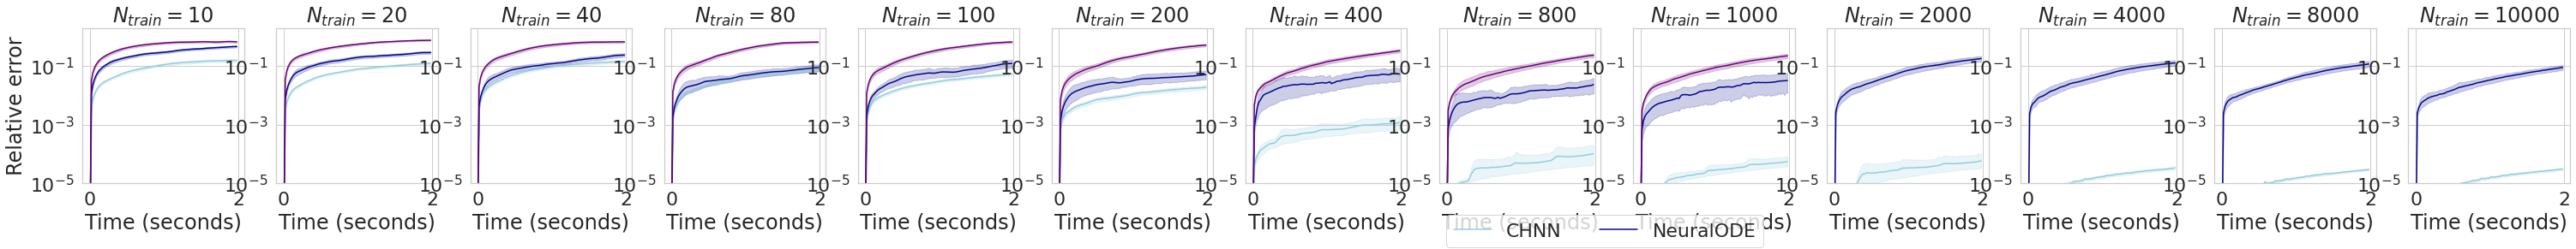

In [13]:
n_plots = len(df["n_train"].unique())
fig, axes = plt.subplots(ncols=n_plots, figsize=(4 * n_plots, 4))
for n_train, ax in zip(df["n_train"].unique(), axes):
    data = df.loc[(df["Series"] == "avg_rel_err_pred") & (df["n_train"] == n_train)]
    sns.lineplot(data=data, x="time", y="value", hue="Network", ax=ax, ci=95)
    ax.set(yscale="log", xlabel="Time (seconds)", title=r"$N_{train}=$" + f"{n_train}", ylim=(1e-5, 2))
    ax.set(ylabel="")
    ax.legend().remove()
axes[0].set(ylabel="Relative error")
handles, labels = axes[-1].get_legend_handles_labels()
labels = labels[1:] # Get rid of legend title
#fig.legend(handles, labels, loc='upper center')
fig.subplots_adjust(bottom=0.25)
fig.legend(labels=labels, bbox_to_anchor=(0., 0., 1.0, 0.1), loc="lower center", ncol=len(labels), borderaxespad=0.1)

In [14]:
df.head()

,n_train,Network,Series,Batch,time,value
6700,10,CHNN,avg_rel_err_pert,0,0,0.000012
13700,10,CHNN,avg_rel_err_pert,0,0.02,0.000012
20700,10,CHNN,avg_rel_err_pert,0,0.04,0.000012
27700,10,CHNN,avg_rel_err_pert,0,0.06,0.000012
34700,10,CHNN,avg_rel_err_pert,0,0.08,0.000012


In [15]:
df_series = df.pivot_table(index=["n_train", "Network", "Series", "Batch"], columns="time", values="value")
y = df_series.to_numpy()
geom_mean = np.exp(np.trapz(np.log(y + 1e-8), dx=dt, axis=-1) / integration_time)
df_geom_mean = pd.DataFrame(index=df_series.index, data=geom_mean, columns=["Geometric Mean"])
df_geom_mean = df_geom_mean.reset_index()

In [16]:
df_geom_mean

,n_train,Network,Series,Batch,Geometric Mean
0,10,CHNN,avg_rel_err_pert,0,0.000031
1,10,CHNN,avg_rel_err_pert,1,0.000010
2,10,CHNN,avg_rel_err_pert,2,0.000016
3,10,CHNN,avg_rel_err_pert,3,0.000015
4,10,CHNN,avg_rel_err_pert,4,0.000028
...,...,...,...,...,...
6995,10000,NeuralODE,avg_rel_err_pred,95,0.009823
6996,10000,NeuralODE,avg_rel_err_pred,96,0.005957
6997,10000,NeuralODE,avg_rel_err_pred,97,0.019666
6998,10000,NeuralODE,avg_rel_err_pred,98,0.007623


In [17]:
body_args = tuple(run.config["body_args"])
if len(body_args) == 0:
    body_args = ""
elif len(body_args) == 1:
    body_args = f"{body_args[0]}-"
else:
    body_args = f"{body_args}"
    
body_class = run.config["body_class"]
if body_class == "ChainPendulum":
    body_class = "Pendulum"
body = f"{body_args}{body_class}"

In [18]:
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
#colors = [(147/255,205/255,221/255), "#00058a", "#6a0078", (96/255,74/255,123/255), "#8e6100"]
colors = ["#00ABDF", "#00058a", "#6a0078", (96/255,74/255,123/255), "#8e6100"]
sns.set_palette(sns.color_palette(colors))

from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('xtick.major', pad=12)
rc('ytick.major', pad=12)
rc('grid', linewidth=1.3)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1000

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.


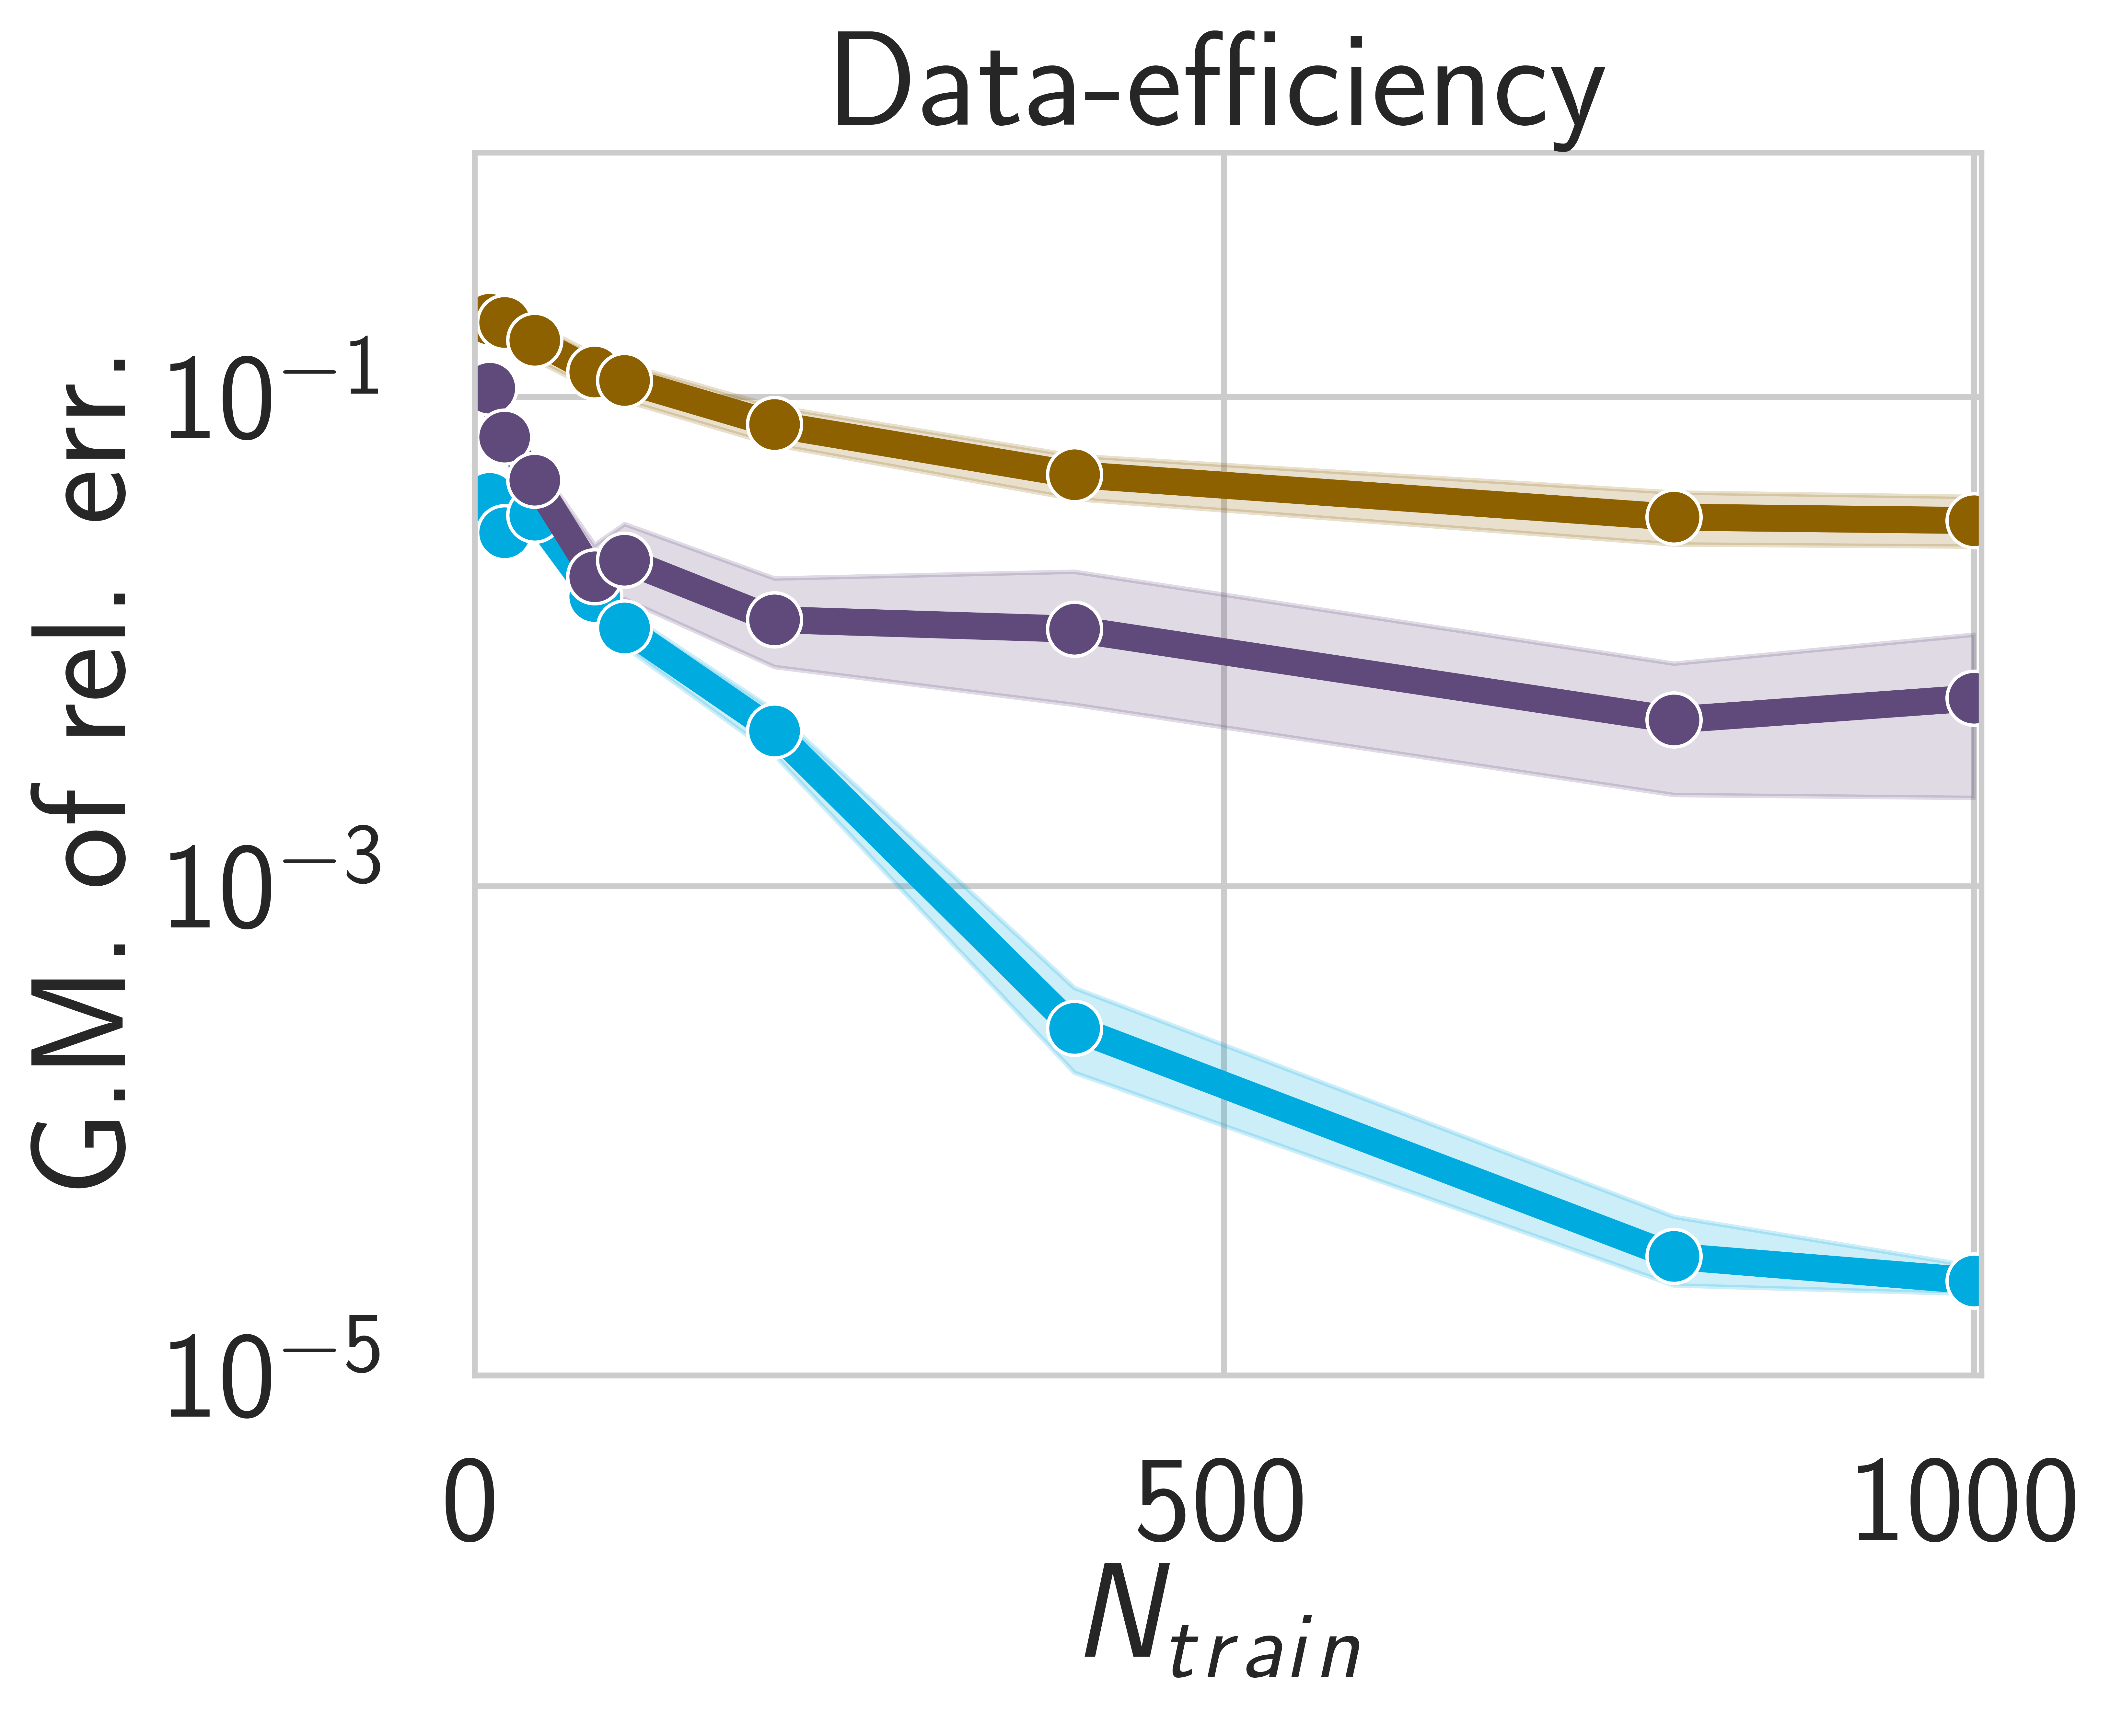

In [19]:
fig, ax = plt.subplots(figsize=(6, 5))
g=sns.lineplot(data=df_geom_mean[df_geom_mean["n_train"] <= 1000], x="n_train", y="Geometric Mean",
             ci=95, hue="Network", ax=ax,
             markers=["o"]*df_geom_mean["Network"].nunique(),
             #markers=True,
             dashes=False,
             style="Network",
             palette=["C0", "C3", "C4"],
             lw=6,
             markersize=12,
            )
ax.set_ylabel("G.M. of rel. err.")
ax.set_xlabel(r"$N_{train}$")
ax.set_title("Data-efficiency")
ax.set(yscale="log", 
       xscale="linear",
       ylim=(1e-5, 1),
       xlim=(0, 1e3+5),
       #xticks=[100, 200, 400, 800, 1000],
      )
#g.set_yticklabels(g.get_yticks(), size = 50)
ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
labels = labels[1:] # Remove title
#fig.subplots_adjust(bottom=0.32, right=1, top=1)
#fig.legend(labels=labels, bbox_to_anchor=(0.05, 0.005, 1.1, 0.), loc="lower center", ncol=len(labels), handlelength=1.5, handletextpad=0.5, borderaxespad=0.0, mode="expand",
           #prop={"size": 50}
#          )


In [20]:
mpl.rcParams['figure.dpi'] = 1000
fig2, ax2 = plt.subplots(figsize=(30, 1))
handles, labels = ax.get_legend_handles_labels()
leg = fig2.legend(labels=labels[1:], handles=handles[1:],
            loc="center", ncol=len(labels),
            mode="expand",
            prop={"size": 80},
            handletextpad=0.5,)
ax2.grid(False)

# Hide axes ticks
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis('off')
for i in leg.legendHandles:
    i.set_linewidth(10)
fig2.savefig("front-fig-legend.png", bbox_inches="tight")

In [21]:
0.006361195290730658 / (2.4378567354783626e-05)

260.9339260242644

In [22]:
df_geom_mean[(df_geom_mean["n_train"] == 1000)
             & (df_geom_mean["Network"] == "CHNN")]["Geometric Mean"].mean()

2.4378566915828212e-05

In [23]:
df_geom_mean[(df_geom_mean["n_train"] == 1000)
             & (df_geom_mean["Network"] == "HNN")]["Geometric Mean"].mean()

0.005887636531516966

In [24]:
df_geom_mean[(df_geom_mean["n_train"] == 1000)
             & (df_geom_mean["Network"] == "CHNN")]["Geometric Mean"].mean()

2.4378566915828212e-05

In [25]:
mpl.rcParams['figure.dpi'] = 1000
fig.savefig("data-efficiency-gyroscope.png", bbox_inches="tight")